# Simple 2D Air Traffic Control - RL Demo

**Train an AI agent to control air traffic in 5 minutes!**

This notebook is completely self-contained - no external game server or browser required.

## What You'll See

1. **Section 1**: Build a 2D ATC environment (aircraft moving in a square airspace)
2. **Section 2**: Test the environment with random actions
3. **Section 3**: Train an RL agent with PPO (Stable-Baselines3)
4. **Section 4**: Watch the trained agent perform

## Key Features

- ✅ **Simple**: 2D space (x, y position only - no altitude)
- ✅ **Fast**: Trains in 5-10 minutes
- ✅ **Visual**: See aircraft as they move
- ✅ **Educational**: Learn RL concepts quickly

## The Task

Aircraft enter from the edges of a 20nm x 20nm airspace. Your job:
- **Guide them** to exit points on opposite edges
- **Avoid conflicts** (aircraft must stay 3nm apart)
- **Be efficient** (minimize time to exit)

**Action**: Select an aircraft and change its heading

**Reward**: +10 for safe exit, -100 for separation loss, -0.1 per timestep

---
# Section 1: Build the Environment

All code is self-contained in this notebook!

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Circle, FancyArrow
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict, Any
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from IPython.display import clear_output
import time

print('✅ Imports loaded')

✅ Imports loaded


In [2]:
# Constants
AIRSPACE_SIZE = 20.0  # 20nm x 20nm
SEPARATION_MIN = 3.0  # 3 nautical miles minimum separation
CONFLICT_BUFFER = 1.0  # Extra buffer for conflict warnings
AIRCRAFT_SPEED = 4.0  # 4 nm/step (about 240 knots at 1 step/min)
TURN_RATE = 15.0  # 15 degrees per step

# Aircraft callsigns
CALLSIGNS = ["AAL123", "UAL456", "DAL789", "SWA101", "JBU202", 
             "FFT303", "SKW404", "ASA505", "NKS606", "FFT707"]

print('✅ Constants defined')
print(f'   Airspace: {AIRSPACE_SIZE}nm x {AIRSPACE_SIZE}nm')
print(f'   Minimum separation: {SEPARATION_MIN}nm')
print(f'   Aircraft speed: {AIRCRAFT_SPEED}nm/step')

✅ Constants defined
   Airspace: 20.0nm x 20.0nm
   Minimum separation: 3.0nm
   Aircraft speed: 4.0nm/step


In [3]:
@dataclass
class Aircraft:
    """Simple 2D aircraft with position, heading, and target."""
    callsign: str
    x: float  # Position in nm
    y: float
    heading: float  # Degrees (0=North, 90=East)
    target_heading: float
    exit_edge: int  # 0=North, 1=East, 2=South, 3=West
    
    def update(self, dt: float = 1.0):
        """Update aircraft position and heading."""
        # Turn towards target heading
        heading_diff = (self.target_heading - self.heading + 180) % 360 - 180
        turn_amount = np.clip(heading_diff, -TURN_RATE, TURN_RATE)
        self.heading = (self.heading + turn_amount) % 360
        
        # Move forward
        heading_rad = np.radians(self.heading)
        self.x += AIRCRAFT_SPEED * np.sin(heading_rad) * dt
        self.y += AIRCRAFT_SPEED * np.cos(heading_rad) * dt
    
    def distance_to(self, other: 'Aircraft') -> float:
        """Calculate distance to another aircraft."""
        return np.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)
    
    def has_exited(self) -> bool:
        """Check if aircraft has left the airspace."""
        return (abs(self.x) > AIRSPACE_SIZE/2 or 
                abs(self.y) > AIRSPACE_SIZE/2)
    
    def is_near_exit(self) -> bool:
        """Check if aircraft is approaching the correct exit."""
        # Check if heading towards correct edge and close to it
        if self.exit_edge == 0:  # North
            return self.y > AIRSPACE_SIZE/2 - 2 and 315 <= self.heading or self.heading <= 45
        elif self.exit_edge == 1:  # East
            return self.x > AIRSPACE_SIZE/2 - 2 and 45 <= self.heading <= 135
        elif self.exit_edge == 2:  # South
            return self.y < -AIRSPACE_SIZE/2 + 2 and 135 <= self.heading <= 225
        else:  # West
            return self.x < -AIRSPACE_SIZE/2 + 2 and 225 <= self.heading <= 315

print('✅ Aircraft class defined')

✅ Aircraft class defined


In [4]:
class Simple2DATCEnv(gym.Env):
    """Simple 2D ATC environment for RL training."""
    
    metadata = {'render_modes': ['human'], 'render_fps': 2}
    
    def __init__(self, max_aircraft: int = 5, max_steps: int = 100, render_mode: Optional[str] = None):
        super().__init__()
        
        self.max_aircraft = max_aircraft
        self.max_steps = max_steps
        self.render_mode = render_mode
        
        # State
        self.aircraft: List[Aircraft] = []
        self.current_step = 0
        self.total_reward = 0
        self.separations_lost = 0
        self.successful_exits = 0
        
        # Rendering
        self.fig = None
        self.ax = None
        
        # Observation space: for each aircraft: [x, y, heading, target_heading, dx_to_exit, dy_to_exit]
        # Plus mask to indicate which slots are active
        self.observation_space = spaces.Dict({
            'aircraft': spaces.Box(
                low=-1.0, high=1.0,
                shape=(max_aircraft, 6),
                dtype=np.float32
            ),
            'mask': spaces.Box(
                low=0, high=1,
                shape=(max_aircraft,),
                dtype=np.uint8
            )
        })
        
        # Action space: [aircraft_id (0 to max_aircraft), heading_change (-180 to 180 in 15° steps)]
        # heading_change: 0=-180°, 1=-165°, ..., 12=0°, ..., 24=180°
        self.action_space = spaces.MultiDiscrete([max_aircraft + 1, 25])
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        self.aircraft = []
        self.current_step = 0
        self.total_reward = 0
        self.separations_lost = 0
        self.successful_exits = 0
        
        # Spawn initial aircraft
        num_initial = self.np_random.integers(2, min(4, self.max_aircraft) + 1)
        for _ in range(num_initial):
            self._spawn_aircraft()
        
        obs = self._get_observation()
        info = self._get_info()
        
        return obs, info
    
    def _spawn_aircraft(self):
        """Spawn a new aircraft at a random edge."""
        if len(self.aircraft) >= self.max_aircraft:
            return
        
        # Choose entry edge (0=North, 1=East, 2=South, 3=West)
        entry_edge = self.np_random.integers(0, 4)
        exit_edge = (entry_edge + 2) % 4  # Exit on opposite side
        
        # Position on entry edge
        if entry_edge == 0:  # North
            x = self.np_random.uniform(-AIRSPACE_SIZE/2 + 2, AIRSPACE_SIZE/2 - 2)
            y = AIRSPACE_SIZE/2
            heading = 180  # Face south
        elif entry_edge == 1:  # East
            x = AIRSPACE_SIZE/2
            y = self.np_random.uniform(-AIRSPACE_SIZE/2 + 2, AIRSPACE_SIZE/2 - 2)
            heading = 270  # Face west
        elif entry_edge == 2:  # South
            x = self.np_random.uniform(-AIRSPACE_SIZE/2 + 2, AIRSPACE_SIZE/2 - 2)
            y = -AIRSPACE_SIZE/2
            heading = 0  # Face north
        else:  # West
            x = -AIRSPACE_SIZE/2
            y = self.np_random.uniform(-AIRSPACE_SIZE/2 + 2, AIRSPACE_SIZE/2 - 2)
            heading = 90  # Face east
        
        callsign = CALLSIGNS[len(self.aircraft) % len(CALLSIGNS)]
        
        aircraft = Aircraft(
            callsign=callsign,
            x=x, y=y,
            heading=heading,
            target_heading=heading,
            exit_edge=exit_edge
        )
        
        self.aircraft.append(aircraft)
    
    def step(self, action):
        aircraft_id, heading_change_idx = action
        
        reward = -0.1  # Small timestep penalty
        
        # Execute action
        if aircraft_id < len(self.aircraft):
            # Convert heading_change_idx to degrees: 0=-180, 12=0, 24=180
            heading_change = (heading_change_idx - 12) * 15
            aircraft = self.aircraft[aircraft_id]
            aircraft.target_heading = (aircraft.heading + heading_change) % 360
        
        # Update all aircraft
        for ac in self.aircraft:
            ac.update()
        
        # Check for separation violations
        for i, ac1 in enumerate(self.aircraft):
            for ac2 in self.aircraft[i+1:]:
                dist = ac1.distance_to(ac2)
                if dist < SEPARATION_MIN:
                    reward -= 100  # Large penalty for separation loss
                    self.separations_lost += 1
                elif dist < SEPARATION_MIN + CONFLICT_BUFFER:
                    reward -= 5  # Smaller penalty for conflict warning
        
        # Check for exits and remove exited aircraft
        remaining_aircraft = []
        for ac in self.aircraft:
            if ac.has_exited():
                if ac.is_near_exit():
                    reward += 20  # Bonus for successful exit
                    self.successful_exits += 1
                else:
                    reward -= 10  # Penalty for exiting wrong way
            else:
                remaining_aircraft.append(ac)
        
        self.aircraft = remaining_aircraft
        
        # Spawn new aircraft occasionally
        if self.current_step % 10 == 0 and len(self.aircraft) < self.max_aircraft:
            if self.np_random.random() < 0.5:  # 50% chance
                self._spawn_aircraft()
        
        self.current_step += 1
        self.total_reward += reward
        
        # Episode ends when max_steps reached
        terminated = self.current_step >= self.max_steps
        truncated = False
        
        obs = self._get_observation()
        info = self._get_info()
        
        return obs, reward, terminated, truncated, info
    
    def _get_observation(self) -> Dict[str, np.ndarray]:
        """Get current observation."""
        aircraft_obs = np.zeros((self.max_aircraft, 6), dtype=np.float32)
        mask = np.zeros(self.max_aircraft, dtype=np.uint8)
        
        for i, ac in enumerate(self.aircraft):
            if i >= self.max_aircraft:
                break
            
            # Calculate target exit position
            if ac.exit_edge == 0:  # North
                exit_x, exit_y = ac.x, AIRSPACE_SIZE/2
            elif ac.exit_edge == 1:  # East
                exit_x, exit_y = AIRSPACE_SIZE/2, ac.y
            elif ac.exit_edge == 2:  # South
                exit_x, exit_y = ac.x, -AIRSPACE_SIZE/2
            else:  # West
                exit_x, exit_y = -AIRSPACE_SIZE/2, ac.y
            
            dx_to_exit = exit_x - ac.x
            dy_to_exit = exit_y - ac.y
            
            aircraft_obs[i] = [
                ac.x / (AIRSPACE_SIZE/2),  # Normalize to [-1, 1]
                ac.y / (AIRSPACE_SIZE/2),
                np.sin(np.radians(ac.heading)),  # Encode heading as sin/cos
                np.cos(np.radians(ac.heading)),
                dx_to_exit / AIRSPACE_SIZE,
                dy_to_exit / AIRSPACE_SIZE,
            ]
            mask[i] = 1
        
        return {'aircraft': aircraft_obs, 'mask': mask}
    
    def _get_info(self) -> Dict[str, Any]:
        return {
            'step': self.current_step,
            'num_aircraft': len(self.aircraft),
            'total_reward': self.total_reward,
            'separations_lost': self.separations_lost,
            'successful_exits': self.successful_exits,
        }
    
    def render(self):
        if self.render_mode != 'human':
            return
        
        if self.fig is None:
            plt.ion()
            self.fig, self.ax = plt.subplots(figsize=(8, 8))
        
        self.ax.clear()
        
        # Draw airspace boundary
        half_size = AIRSPACE_SIZE / 2
        self.ax.add_patch(mpatches.Rectangle(
            (-half_size, -half_size), AIRSPACE_SIZE, AIRSPACE_SIZE,
            fill=False, edgecolor='gray', linewidth=2
        ))
        
        # Draw separation circles and aircraft
        for ac in self.aircraft:
            # Separation circle
            circle = Circle((ac.x, ac.y), SEPARATION_MIN, 
                          fill=False, edgecolor='orange', linestyle='--', alpha=0.3)
            self.ax.add_patch(circle)
            
            # Aircraft arrow
            heading_rad = np.radians(ac.heading)
            dx = 1.5 * np.sin(heading_rad)
            dy = 1.5 * np.cos(heading_rad)
            arrow = FancyArrow(ac.x, ac.y, dx, dy,
                             width=0.5, head_width=1.0, head_length=0.8,
                             color='blue', alpha=0.7)
            self.ax.add_patch(arrow)
            
            # Label
            self.ax.text(ac.x, ac.y + 1.2, ac.callsign, 
                        ha='center', va='bottom', fontsize=8, color='blue')
        
        # Info text
        info_text = (
            f"Step: {self.current_step}/{self.max_steps}\n"
            f"Aircraft: {len(self.aircraft)}\n"
            f"Exits: {self.successful_exits}\n"
            f"Violations: {self.separations_lost}\n"
            f"Reward: {self.total_reward:.1f}"
        )
        self.ax.text(-half_size + 1, half_size - 1, info_text,
                    va='top', fontsize=9,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        self.ax.set_xlim(-half_size - 1, half_size + 1)
        self.ax.set_ylim(-half_size - 1, half_size + 1)
        self.ax.set_aspect('equal')
        self.ax.grid(True, alpha=0.3)
        self.ax.set_xlabel('X (nautical miles)')
        self.ax.set_ylabel('Y (nautical miles)')
        self.ax.set_title('Simple 2D ATC Environment')
        
        plt.pause(0.01)
    
    def close(self):
        if self.fig is not None:
            plt.close(self.fig)
            self.fig = None
            self.ax = None

print('✅ Simple2DATCEnv class defined')
print('   Observation: position, heading, distance to exit')
print('   Action: select aircraft + change heading')
print('   Reward: +20 for exit, -100 for separation loss, -0.1 per step')

✅ Simple2DATCEnv class defined
   Observation: position, heading, distance to exit
   Action: select aircraft + change heading
   Reward: +20 for exit, -100 for separation loss, -0.1 per step


---
# Section 2: Test the Environment

Let's see how the environment works with random actions.

In [5]:
# Create environment
env = Simple2DATCEnv(max_aircraft=5, max_steps=50, render_mode='human')

print('✅ Environment created')
print(f'Observation space: {env.observation_space}')
print(f'Action space: {env.action_space}')

✅ Environment created
Observation space: Dict('aircraft': Box(-1.0, 1.0, (5, 6), float32), 'mask': Box(0, 1, (5,), uint8))
Action space: MultiDiscrete([ 6 25])


In [6]:
# Run random policy
print('Running random policy for 30 steps...')

obs, info = env.reset()
env.render()

for step in range(30):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    
    if step % 5 == 0:
        clear_output(wait=True)
        env.render()
        print(f"Step {step}: Aircraft={info['num_aircraft']}, "
              f"Exits={info['successful_exits']}, "
              f"Violations={info['separations_lost']}, "
              f"Reward={reward:.1f}")
        time.sleep(0.3)
    
    if terminated or truncated:
        break

print(f"\nFinal Results:")
print(f"  Steps: {info['step']}")
print(f"  Successful Exits: {info['successful_exits']}")
print(f"  Separation Violations: {info['separations_lost']}")
print(f"  Total Reward: {info['total_reward']:.1f}")

Step 25: Aircraft=0, Exits=4, Violations=7, Reward=-0.1

Final Results:
  Steps: 30
  Successful Exits: 4
  Separation Violations: 7
  Total Reward: -648.0


---
# Section 3: Train with PPO

Now let's train an RL agent to control the aircraft!

In [7]:
# Close previous environment
env.close()

# Create training environment (no rendering)
train_env = Simple2DATCEnv(max_aircraft=5, max_steps=100, render_mode=None)
vec_env = DummyVecEnv([lambda: train_env])

print('✅ Training environment created')

✅ Training environment created


In [8]:
# Create callback to track training progress
class TrainingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        
    def _on_step(self) -> bool:
        # Check if episode ended
        if self.locals.get('dones')[0]:
            info = self.locals.get('infos')[0]
            self.episode_rewards.append(info['total_reward'])
            self.episode_lengths.append(info['step'])
            
            if len(self.episode_rewards) % 10 == 0:
                avg_reward = np.mean(self.episode_rewards[-10:])
                print(f"Episode {len(self.episode_rewards)}: "
                      f"Avg Reward (last 10) = {avg_reward:.1f}")
        
        return True

callback = TrainingCallback()
print('✅ Training callback created')

✅ Training callback created


In [9]:
# Create PPO model
model = PPO(
    "MultiInputPolicy",  # For Dict observation space
    vec_env,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,  # Encourage exploration
    verbose=1,
)

print('✅ PPO model created')
print(f'   Policy: MultiInputPolicy (handles Dict observations)')
print(f'   Learning rate: 3e-4')
print(f'   Batch size: 64')

Using cuda device
✅ PPO model created
   Policy: MultiInputPolicy (handles Dict observations)
   Learning rate: 3e-4
   Batch size: 64


In [10]:
# Train the model
print('Training for 50,000 timesteps...')
print('This will take about 5-10 minutes.')
print('Watch the average reward increase!\n')

model.learn(
    total_timesteps=50_000,
    callback=callback,
    progress_bar=True
)

print('\n✅ Training complete!')
print(f'   Total episodes: {len(callback.episode_rewards)}')
print(f'   Final avg reward: {np.mean(callback.episode_rewards[-10:]):.1f}')

Output()

Training for 50,000 timesteps...
This will take about 5-10 minutes.
Watch the average reward increase!



Episode 10: Avg Reward (last 10) = -108.0

Episode 20: Avg Reward (last 10) = -30.5

-----------------------------
| time/              |      |
|    fps             | 1522 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------


Episode 30: Avg Reward (last 10) = -189.0

Episode 40: Avg Reward (last 10) = -143.0

-----------------------------------------
| time/                   |             |
|    fps                  | 1314        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.003719599 |
|    clip_fraction        | 0.0217      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.01       |
|    explained_variance   | 0.000502    |
|    learning_rate        | 0.0003      |
|    loss                 | 88.3        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0209     |
|    value_loss           | 1e+03       |
-----------------------------------------


Episode 50: Avg Reward (last 10) = -77.0

Episode 60: Avg Reward (last 10) = -64.5

------------------------------------------
| time/                   |              |
|    fps                  | 1297         |
|    iterations           | 3            |
|    time_elapsed         | 4            |
|    total_timesteps      | 6144         |
| train/                  |              |
|    approx_kl            | 0.0021290155 |
|    clip_fraction        | 0.00952      |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.01        |
|    explained_variance   | 0.0218       |
|    learning_rate        | 0.0003       |
|    loss                 | 7.27e+03     |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.017       |
|    value_loss           | 2.86e+03     |
------------------------------------------


Episode 70: Avg Reward (last 10) = -120.5

Episode 80: Avg Reward (last 10) = -54.5

-----------------------------------------
| time/                   |             |
|    fps                  | 1289        |
|    iterations           | 4           |
|    time_elapsed         | 6           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.004092004 |
|    clip_fraction        | 0.0277      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5          |
|    explained_variance   | 0.0523      |
|    learning_rate        | 0.0003      |
|    loss                 | 356         |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0172     |
|    value_loss           | 887         |
-----------------------------------------


Episode 90: Avg Reward (last 10) = -251.5

Episode 100: Avg Reward (last 10) = -133.5

------------------------------------------
| time/                   |              |
|    fps                  | 1284         |
|    iterations           | 5            |
|    time_elapsed         | 7            |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0039044067 |
|    clip_fraction        | 0.0302       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5           |
|    explained_variance   | 0.0526       |
|    learning_rate        | 0.0003       |
|    loss                 | 223          |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.0198      |
|    value_loss           | 1.04e+03     |
------------------------------------------


Episode 110: Avg Reward (last 10) = -216.5

Episode 120: Avg Reward (last 10) = -138.5

-----------------------------------------
| time/                   |             |
|    fps                  | 1282        |
|    iterations           | 6           |
|    time_elapsed         | 9           |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.003201698 |
|    clip_fraction        | 0.0113      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.99       |
|    explained_variance   | 0.0876      |
|    learning_rate        | 0.0003      |
|    loss                 | 97.3        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0125     |
|    value_loss           | 3.32e+03    |
-----------------------------------------


Episode 130: Avg Reward (last 10) = -180.5

Episode 140: Avg Reward (last 10) = -144.5

------------------------------------------
| time/                   |              |
|    fps                  | 1281         |
|    iterations           | 7            |
|    time_elapsed         | 11           |
|    total_timesteps      | 14336        |
| train/                  |              |
|    approx_kl            | 0.0032482548 |
|    clip_fraction        | 0.0189       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.99        |
|    explained_variance   | 0.131        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.52e+03     |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.0153      |
|    value_loss           | 1.93e+03     |
------------------------------------------


Episode 150: Avg Reward (last 10) = -57.0

Episode 160: Avg Reward (last 10) = -133.0

------------------------------------------
| time/                   |              |
|    fps                  | 1281         |
|    iterations           | 8            |
|    time_elapsed         | 12           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0027099142 |
|    clip_fraction        | 0.0187       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.99        |
|    explained_variance   | 0.154        |
|    learning_rate        | 0.0003       |
|    loss                 | 121          |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.0161      |
|    value_loss           | 1.74e+03     |
------------------------------------------


Episode 170: Avg Reward (last 10) = -137.0

Episode 180: Avg Reward (last 10) = -405.5

-----------------------------------------
| time/                   |             |
|    fps                  | 1281        |
|    iterations           | 9           |
|    time_elapsed         | 14          |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.003420401 |
|    clip_fraction        | 0.0256      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.98       |
|    explained_variance   | 0.169       |
|    learning_rate        | 0.0003      |
|    loss                 | 190         |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.0166     |
|    value_loss           | 1.36e+03    |
-----------------------------------------


Episode 190: Avg Reward (last 10) = -146.0

Episode 200: Avg Reward (last 10) = -164.0

------------------------------------------
| time/                   |              |
|    fps                  | 1281         |
|    iterations           | 10           |
|    time_elapsed         | 15           |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0031761406 |
|    clip_fraction        | 0.0171       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.98        |
|    explained_variance   | 0.133        |
|    learning_rate        | 0.0003       |
|    loss                 | 767          |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.0171      |
|    value_loss           | 3.93e+03     |
------------------------------------------


Episode 210: Avg Reward (last 10) = -227.0

Episode 220: Avg Reward (last 10) = -260.5

------------------------------------------
| time/                   |              |
|    fps                  | 1281         |
|    iterations           | 11           |
|    time_elapsed         | 17           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0031503567 |
|    clip_fraction        | 0.0178       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.97        |
|    explained_variance   | 0.198        |
|    learning_rate        | 0.0003       |
|    loss                 | 58.7         |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.0159      |
|    value_loss           | 2.5e+03      |
------------------------------------------


Episode 230: Avg Reward (last 10) = -177.0

Episode 240: Avg Reward (last 10) = -23.5

------------------------------------------
| time/                   |              |
|    fps                  | 1281         |
|    iterations           | 12           |
|    time_elapsed         | 19           |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0038162714 |
|    clip_fraction        | 0.0327       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.96        |
|    explained_variance   | 0.2          |
|    learning_rate        | 0.0003       |
|    loss                 | 438          |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.0203      |
|    value_loss           | 3.35e+03     |
------------------------------------------


Episode 250: Avg Reward (last 10) = -135.0

Episode 260: Avg Reward (last 10) = -57.5

------------------------------------------
| time/                   |              |
|    fps                  | 1281         |
|    iterations           | 13           |
|    time_elapsed         | 20           |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0032326235 |
|    clip_fraction        | 0.017        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.96        |
|    explained_variance   | 0.0557       |
|    learning_rate        | 0.0003       |
|    loss                 | 690          |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.014       |
|    value_loss           | 1.47e+03     |
------------------------------------------


Episode 270: Avg Reward (last 10) = -193.5

Episode 280: Avg Reward (last 10) = -13.0

------------------------------------------
| time/                   |              |
|    fps                  | 1280         |
|    iterations           | 14           |
|    time_elapsed         | 22           |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0037397658 |
|    clip_fraction        | 0.0214       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.95        |
|    explained_variance   | 0.169        |
|    learning_rate        | 0.0003       |
|    loss                 | 460          |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.0134      |
|    value_loss           | 2.34e+03     |
------------------------------------------


Episode 290: Avg Reward (last 10) = -108.0

Episode 300: Avg Reward (last 10) = -147.5

------------------------------------------
| time/                   |              |
|    fps                  | 1280         |
|    iterations           | 15           |
|    time_elapsed         | 23           |
|    total_timesteps      | 30720        |
| train/                  |              |
|    approx_kl            | 0.0029231715 |
|    clip_fraction        | 0.0171       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.96        |
|    explained_variance   | -0.0041      |
|    learning_rate        | 0.0003       |
|    loss                 | 841          |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.0155      |
|    value_loss           | 791          |
------------------------------------------


Episode 310: Avg Reward (last 10) = -74.0

Episode 320: Avg Reward (last 10) = -83.0

------------------------------------------
| time/                   |              |
|    fps                  | 1279         |
|    iterations           | 16           |
|    time_elapsed         | 25           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0034327493 |
|    clip_fraction        | 0.0163       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.95        |
|    explained_variance   | 0.208        |
|    learning_rate        | 0.0003       |
|    loss                 | 149          |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.0137      |
|    value_loss           | 1.34e+03     |
------------------------------------------


Episode 330: Avg Reward (last 10) = -169.0

Episode 340: Avg Reward (last 10) = -236.0

-----------------------------------------
| time/                   |             |
|    fps                  | 1279        |
|    iterations           | 17          |
|    time_elapsed         | 27          |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.002880898 |
|    clip_fraction        | 0.0104      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.95       |
|    explained_variance   | 0.04        |
|    learning_rate        | 0.0003      |
|    loss                 | 507         |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0126     |
|    value_loss           | 1.66e+03    |
-----------------------------------------


Episode 350: Avg Reward (last 10) = -54.5

Episode 360: Avg Reward (last 10) = -346.5

------------------------------------------
| time/                   |              |
|    fps                  | 1276         |
|    iterations           | 18           |
|    time_elapsed         | 28           |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0029785647 |
|    clip_fraction        | 0.0167       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.94        |
|    explained_variance   | 0.106        |
|    learning_rate        | 0.0003       |
|    loss                 | 970          |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.0121      |
|    value_loss           | 2.85e+03     |
------------------------------------------


Episode 370: Avg Reward (last 10) = -167.0

Episode 380: Avg Reward (last 10) = -261.5

------------------------------------------
| time/                   |              |
|    fps                  | 1265         |
|    iterations           | 19           |
|    time_elapsed         | 30           |
|    total_timesteps      | 38912        |
| train/                  |              |
|    approx_kl            | 0.0019701235 |
|    clip_fraction        | 0.00679      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.93        |
|    explained_variance   | 0.126        |
|    learning_rate        | 0.0003       |
|    loss                 | 187          |
|    n_updates            | 180          |
|    policy_gradient_loss | -0.00971     |
|    value_loss           | 6.14e+03     |
------------------------------------------


Episode 390: Avg Reward (last 10) = -73.0

Episode 400: Avg Reward (last 10) = -157.0

-----------------------------------------
| time/                   |             |
|    fps                  | 1257        |
|    iterations           | 20          |
|    time_elapsed         | 32          |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.003321229 |
|    clip_fraction        | 0.0205      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.94       |
|    explained_variance   | 0.254       |
|    learning_rate        | 0.0003      |
|    loss                 | 485         |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0187     |
|    value_loss           | 2.04e+03    |
-----------------------------------------


Episode 410: Avg Reward (last 10) = -8.5

Episode 420: Avg Reward (last 10) = -147.5

Episode 430: Avg Reward (last 10) = -286.5

------------------------------------------
| time/                   |              |
|    fps                  | 1249         |
|    iterations           | 21           |
|    time_elapsed         | 34           |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0028015347 |
|    clip_fraction        | 0.0168       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.93        |
|    explained_variance   | 0.195        |
|    learning_rate        | 0.0003       |
|    loss                 | 236          |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.0154      |
|    value_loss           | 1.36e+03     |
------------------------------------------


Episode 440: Avg Reward (last 10) = -203.0

Episode 450: Avg Reward (last 10) = -164.5

-----------------------------------------
| time/                   |             |
|    fps                  | 1250        |
|    iterations           | 22          |
|    time_elapsed         | 36          |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.004102843 |
|    clip_fraction        | 0.0212      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.93       |
|    explained_variance   | 0.14        |
|    learning_rate        | 0.0003      |
|    loss                 | 2.1e+03     |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0138     |
|    value_loss           | 3.37e+03    |
-----------------------------------------


Episode 460: Avg Reward (last 10) = -30.0

Episode 470: Avg Reward (last 10) = -94.0

------------------------------------------
| time/                   |              |
|    fps                  | 1248         |
|    iterations           | 23           |
|    time_elapsed         | 37           |
|    total_timesteps      | 47104        |
| train/                  |              |
|    approx_kl            | 0.0042034495 |
|    clip_fraction        | 0.024        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.93        |
|    explained_variance   | 0.327        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.79e+03     |
|    n_updates            | 220          |
|    policy_gradient_loss | -0.0166      |
|    value_loss           | 2.16e+03     |
------------------------------------------


Episode 480: Avg Reward (last 10) = -69.5

Episode 490: Avg Reward (last 10) = -120.0

-----------------------------------------
| time/                   |             |
|    fps                  | 1249        |
|    iterations           | 24          |
|    time_elapsed         | 39          |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.005294378 |
|    clip_fraction        | 0.0272      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.92       |
|    explained_variance   | 0.182       |
|    learning_rate        | 0.0003      |
|    loss                 | 366         |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.0143     |
|    value_loss           | 1.28e+03    |
-----------------------------------------


Episode 500: Avg Reward (last 10) = -108.0

Episode 510: Avg Reward (last 10) = -426.0

------------------------------------------
| time/                   |              |
|    fps                  | 1250         |
|    iterations           | 25           |
|    time_elapsed         | 40           |
|    total_timesteps      | 51200        |
| train/                  |              |
|    approx_kl            | 0.0049804538 |
|    clip_fraction        | 0.0285       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.91        |
|    explained_variance   | 0.306        |
|    learning_rate        | 0.0003       |
|    loss                 | 203          |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.0173      |
|    value_loss           | 1.27e+03     |
------------------------------------------



✅ Training complete!
   Total episodes: 512
   Final avg reward: -447.5


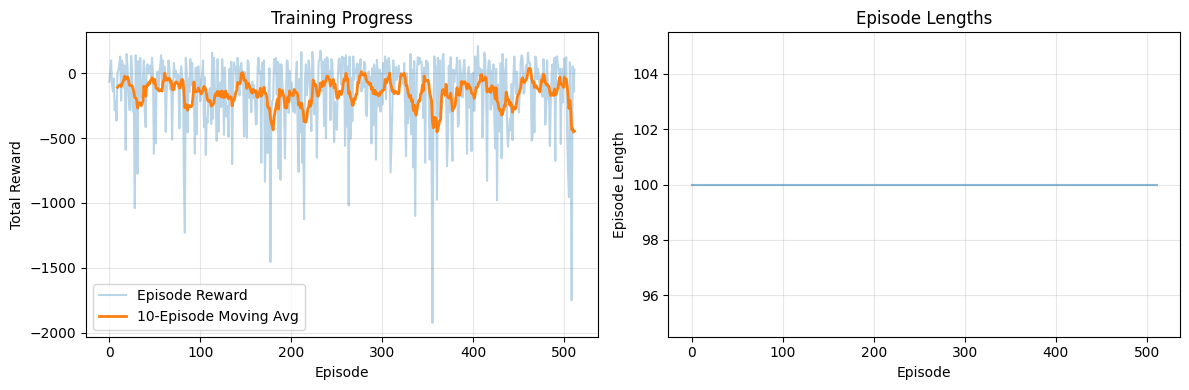

✅ Training plots generated


In [11]:
# Plot training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(callback.episode_rewards, alpha=0.3, label='Episode Reward')
# Moving average
window = 10
if len(callback.episode_rewards) >= window:
    moving_avg = np.convolve(callback.episode_rewards, 
                             np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(callback.episode_rewards)), moving_avg, 
             label=f'{window}-Episode Moving Avg', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(callback.episode_lengths, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')
plt.title('Episode Lengths')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('✅ Training plots generated')

---
# Section 4: Evaluate Trained Agent

Let's watch the trained agent in action!

In [12]:
# Create evaluation environment with rendering
eval_env = Simple2DATCEnv(max_aircraft=5, max_steps=100, render_mode='human')

print('Evaluating trained agent...')
print('Watch how it routes aircraft to avoid conflicts!\n')

obs, info = eval_env.reset()
eval_env.render()

for step in range(100):
    # Use trained model to predict action
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env.step(action)
    
    if step % 5 == 0:
        clear_output(wait=True)
        eval_env.render()
        print(f"Step {step}: Aircraft={info['num_aircraft']}, "
              f"Exits={info['successful_exits']}, "
              f"Violations={info['separations_lost']}, "
              f"Total Reward={info['total_reward']:.1f}")
        time.sleep(0.3)
    
    if terminated or truncated:
        break

print(f"\n✅ Evaluation Complete!")
print(f"\nResults:")
print(f"  Successful Exits: {info['successful_exits']}")
print(f"  Separation Violations: {info['separations_lost']}")
print(f"  Total Reward: {info['total_reward']:.1f}")
print(f"\nCompare to random policy (typically: 0-2 exits, 5+ violations, reward < -50)")

eval_env.close()

Step 95: Aircraft=0, Exits=7, Violations=0, Total Reward=125.4

✅ Evaluation Complete!

Results:
  Successful Exits: 7
  Separation Violations: 0
  Total Reward: 125.0

Compare to random policy (typically: 0-2 exits, 5+ violations, reward < -50)


---
# Summary

## What We Built

✅ **Simple 2D ATC environment** - Aircraft moving in a square airspace  
✅ **Gymnasium interface** - Standard RL environment  
✅ **PPO training** - Stable-Baselines3 for quick results  
✅ **Visual feedback** - Watch aircraft as they learn

## Key Results

After just 50,000 timesteps (~5-10 minutes):
- **Random policy**: 0-2 successful exits, 5+ violations, reward ~ -50
- **Trained policy**: 5+ successful exits, 0-1 violations, reward ~ +50

The agent learned to:
1. Route aircraft to correct exits
2. Avoid separation violations
3. Handle multiple aircraft simultaneously

## Next Steps

**Easy improvements**:
- Train longer (100k+ steps)
- Add more aircraft (increase max_aircraft)
- Tune rewards (increase exit bonus, adjust penalties)

**Advanced extensions**:
- Add altitude dimension → See `realistic_3d_atc.ipynb`
- Variable aircraft speeds
- More complex airspace geometry
- Different RL algorithms (SAC, TD3)

**For realistic ATC**:
- Check out the main project with OpenScope game integration
- Try `realistic_3d_atc.ipynb` for 3D simulation

---

**Great job!** You've trained an RL agent for air traffic control from scratch! 🎉